# Assignment 4: Finite-Time Optimal Control

University of California Berkeley

ME C231A, EE C220B, Experiential Advanced Control I

**Released:** 10/10/2023

**Due on Gradescope:** 10/22/2023 at 11:59pm

**Submission Instructions:**


*   Make a copy of this colab notebook in your drive. (File -> Save a copy in Drive)
*   Complete your homework by writing code in your copy of the notebook and writing answers to the written questions.
* When you are ready to submit, run all your cells so the outputs show in this notebook.
* Save your colab notebook as a PDF. (File -> Print -> Save as PDF).
* If required, combine the colab PDF with a PDF of any written answers.
* Submit two files on **Gradescope**:
  * PDF of Colab answers and written answers. Please select corresponding pages of your PDF for each question--makes it much easier to grade!!
  * Python notebook of Colab (File -> Download -> Download .ipynb)

***

These notes were developed by Fionna Kopp, Charlott Vallon, Roya Firoozi and Francesco Borrelli at UC Berkeley. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

If you are enrolled in ME C231A/EE C220B you may take notes and make copies of course materials for your own use. You may also share those materials with another student who is registered and enrolled in this course, and with DSP.

You may not reproduce, distribute or display lecture notes or recordings or course materials in any other way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Berkeley Code of Student Conduct, including Sections 102.23 and 102.25.

***

**NOTE**: Remove `...` in cells throughout this Colab note, and fill in your code.

In [4]:
# Run this cell only if you are using Google Colab.

# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64
  !pip install ttictoc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.8 MB/s eta 0:00:00
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 120874 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected pac

***

# <font color=blue> 1. Finite-Time Optimal Control of a Vehicle </font>

In this question you solve a nonlinear finite-time optimal control problem, which is similar to the unicycle example discussed in class. For both parts of the question (part (a) and part (b)), please print out 4 subplots (one for each state vs time). Also print a simple plot showing the vehicle motion ($x_k$ vs $y_k$). In addition, print out 2 subplots (one for each control input vs time). Also, turn in the code for both parts (a) and (b), which formulate the optimization problems described below. For both parts, specify IPOPT as the solver in $\texttt{pyomo}$.

Consider the same simplified kinematic bicycle model used in Homework 1.

\begin{eqnarray}
\dot{x} &=& v\cos(\psi+\beta)\nonumber\\
\dot{y} &=& v\sin(\psi+\beta)\nonumber\\
\dot{v} &=& a \nonumber\\
\dot{\psi} &=& \frac{v}{l_r}\sin(\beta)\nonumber\\
\beta &=& \tan^{-1} \left( \frac{l_r}{l_f+l_r} \tan(\delta_f)\right) \nonumber
\end{eqnarray}


where
\begin{align}
x &= \text{ global x CoG coordinate} \nonumber \\
y &= \text{ global y CoG coordinate} \nonumber \\
v &= \text{ speed of the vehicle} \nonumber \\
\psi &= \text{ global heading angle} \nonumber \\
\beta &= \text{ angle of the current velocity with respect to the longitudinal axis of the car} \nonumber \\
a &= \text{ acceleration of the center of mass into this direction} \nonumber \\
l_r &= \text{ distance from the center of mass of the vehicle to the rear axle} \nonumber \\
l_f &= \text{ distance from the center of mass of the vehicle to the front axle} \nonumber \\
\delta_f &= \text{ steering angle of the front wheels with respect to the longitudinal axis of the car} \nonumber
\end{align}

Collect the states in one vector $z = [x, y, v, \psi]^T$, and the inputs as $u = [a, \beta]^T$. Obtain a discrete-time model by using Forward Euler Discretization with sampling time $\Delta t = 0.2$. Use $l_f=l_r = 1.738$ in the simulation. You are asked to formulate and solve a parking problem as a finite-time optimal control problem. The vehicle starts from the initial state $\bar{z}_0 = [\hspace{0.5mm}0, \hspace{1mm}3,\hspace{1mm} 0,\hspace{1mm} 0\hspace{0.5mm}]^T$. Our goal is to park the vehicle in the terminal state $\bar{z}_N=[0,0,0,-\pi/2]^T$. Set the horizon $N = 70$ and the state constraints to be: $[-20, \hspace{2.5mm}-5,\hspace{2.5mm}-10, \hspace{2.5mm}-2\pi]^T \leq z(k) \leq [20, \hspace{2.5mm}10,\hspace{2.5mm}10, \hspace{2.5mm}2\pi]^T $. Solve the finite time optimal control problem and plot the results.

$\textbf{Part (a)}$

Parking Problem Formulation 1

Consider the finite time optimal control problem defined below. Formulate and solve the optimzation problem in $\texttt{pyomo}$.

\begin{align}
\min_{z_0,\ldots,z_N,u_0,\ldots,u_{N-1}} & \sum_{k=N-2}^{N} \|z_k  - \bar{z}_N \|_2^2 \nonumber\\
& z_{k+1} = z_k+f(z_k,u_k)\Delta t &&~\forall k = \left\{0,\ldots,N-1 \right\} \nonumber\\
& z_{min} \leq z_k \leq z_{max} &&~\forall k = \left\{0,\ldots,N \right\} \nonumber\\
& u_{min} \leq u_k \leq u_{max} &&~\forall k = \left\{0,\ldots,N-1 \right\} \nonumber\\
& | \beta_{k+1} - \beta_k | \leq \beta_{d} &&~\forall k = \left\{0,\ldots,N-2 \right\} \nonumber\\
%& |a(k+1) - a(k)| \leq a_d &&~\forall k = \left\{0,\ldots,H_p-1 \right\} \nonumber\\
& z_0 = \bar{z}_0\nonumber\nonumber\\
& z_N = \bar{z}_N\nonumber
\end{align}
Consider the following constraints:

1. The difference of current and previous steering commands are bounded by $\pm 0.2 $ rad. (i.e. $\beta_d = 0.2$)
2. The accelerations are bounded by $|a(k)| \leq 0.3 \ \text{m/s}^2$.
3. The steering control inputs are limited to $|\beta(k)| \leq 0.6$ rad.

### <font color=red> Delivarable 1a (15 pts): write your answer in the code cell below.</font>

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


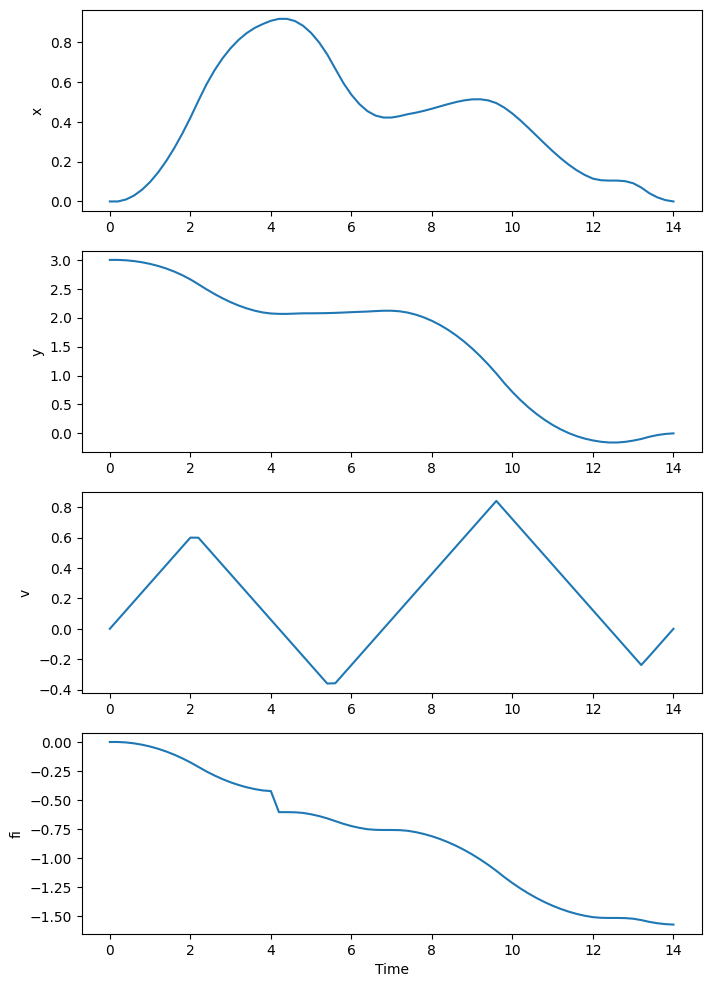

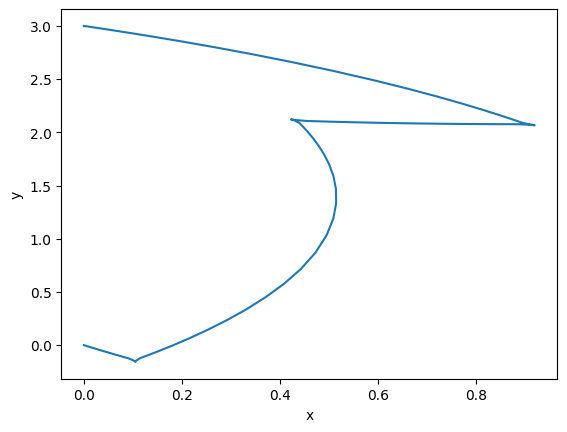

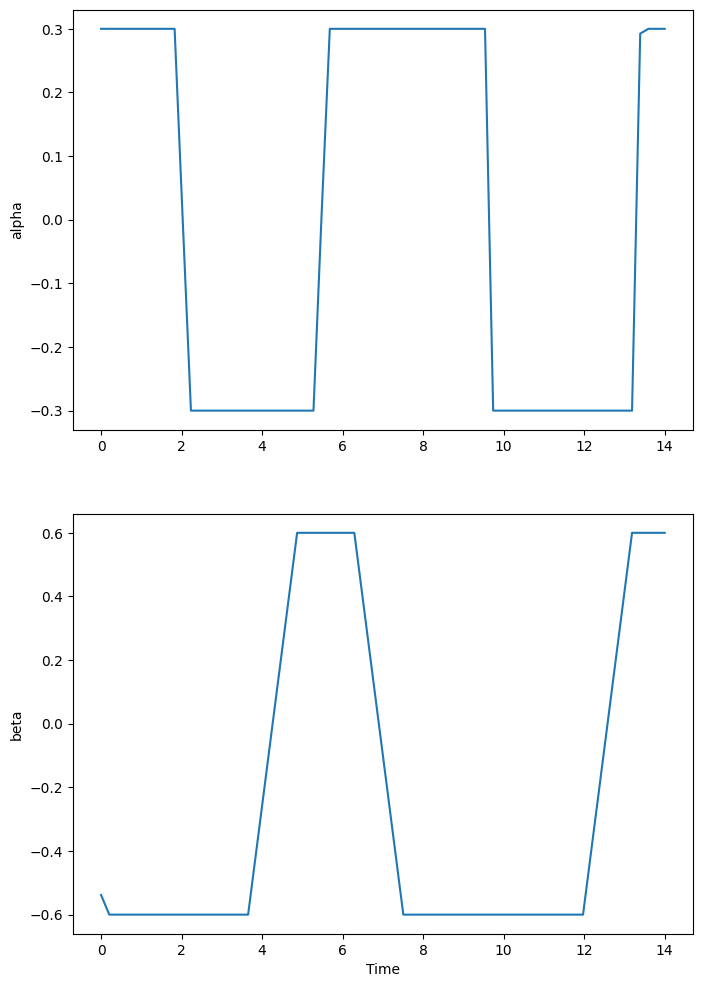

In [13]:
# Write your code here:

import pyomo.environ as pyo
import numpy as np


deltaT=0.2
N=70
lr=1.738
lf=1.738

model = pyo.ConcreteModel()

model.x = pyo.Var(pyo.RangeSet(0,N), bounds=[-20,20]) # This creates a decision variable vector z with index 0 and 1. You can call model.z[0] and model.z[1]
model.y = pyo.Var(pyo.RangeSet(0,N), bounds=[-5,10])
model.v = pyo.Var(pyo.RangeSet(0,N), bounds=[-10,10])
model.fi = pyo.Var(pyo.RangeSet(0,N), bounds=[-2*np.pi,2*np.pi])

model.alpha = pyo.Var(pyo.RangeSet(0,N-1),bounds=(-0.3,0.3))
model.beta = pyo.Var(pyo.RangeSet(0,N-1),bounds=(-0.6,0.6))

model.obj=pyo.Objective(expr=sum(model.x[i]**2+model.y[i]**2+model.v[i]**2+(model.fi[i]+np.pi/2)**2 for i in range(N-2,N+1)),sense=pyo.minimize)

model.Constraint=pyo.ConstraintList()

model.Constraint.add(expr=model.x[0]==0)
model.Constraint.add(expr=model.y[0]==3)
model.Constraint.add(expr=model.v[0]==0)
model.Constraint.add(expr=model.fi[0]==0)

model.Constraint.add(expr=model.x[N]==0)
model.Constraint.add(expr=model.y[N]==0)
model.Constraint.add(expr=model.v[N]==0)
model.Constraint.add(expr=model.fi[N]==-np.pi/2)

for i in range(1,N+1):
    model.Constraint.add(expr=model.x[i]==model.x[i-1]+model.v[i-1]*pyo.cos(model.fi[i-1]+model.beta[i-1])*deltaT)
    model.Constraint.add(expr=model.y[i]==model.y[i-1]+model.v[i-1]*pyo.sin(model.fi[i-1]+model.beta[i-1])*deltaT)
    model.Constraint.add(expr=model.v[i]==model.v[i-1]+model.alpha[i-1]*deltaT)
    model.Constraint.add(expr=model.fi[i]==model.fi[i-1]+model.v[i-1]*pyo.sin(model.beta[i-1])*deltaT/lr)

for i in range(N-1):
    model.Constraint.add(expr=model.beta[i+1]-model.beta[i]<=0.2)
    model.Constraint.add(expr=model.beta[i+1]-model.beta[i]>=-0.2)


solution=pyo.SolverFactory('ipopt').solve(model)

x_values = np.zeros(N+1)
y_values = np.zeros(N+1)
v_values = np.zeros(N+1)
fi_values = np.zeros(N+1)
alpha_values = np.zeros(N)
beta_values = np.zeros(N)

for i in range(N+1):
    x_values[i] = pyo.value(model.x[i])
    y_values[i] = pyo.value(model.y[i])
    v_values[i] = pyo.value(model.v[i])
    fi_values[i] = pyo.value(model.fi[i])

for i in range(N):
    alpha_values[i] = pyo.value(model.alpha[i])
    beta_values[i] = pyo.value(model.beta[i])


time=np.linspace(0,N*deltaT,N+1)
time2=np.linspace(0,N*deltaT,N)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(8, 12))

axs[0].plot(time, x_values)
axs[0].set_ylabel('x')

axs[1].plot(time, y_values)
axs[1].set_ylabel('y')

axs[2].plot(time, v_values)
axs[2].set_ylabel('v')

axs[3].plot(time, fi_values)
axs[3].set_ylabel('fi')
plt.xlabel('Time')
plt.show()

plt.plot(x_values, y_values)


plt.xlabel('x')
plt.ylabel('y')

plt.show()


fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].plot(time2, alpha_values)
axs[0].set_ylabel('alpha')

axs[1].plot(time2, beta_values)
axs[1].set_ylabel('beta')
plt.xlabel('Time')
plt.show()



$\textbf{Part (b)}$

Parking Problem Formulation 2

Use formulation 1 and add the additional constraints on the difference between current and previous acceleration to get a smoother parking maneuver:

\begin{align}
|a(k+1) - a(k)| \leq a_d \quad \forall k = {0,\ldots,N-2},
\end{align}

where $a_d = 0.06$ m/s$^2$. Formulate the optimzation problem in $\texttt{pyomo}$.

Show by using plots that you get a smoother control action.

### <font color=red> Delivarable 1b (10 pts): write your answer in the code cell below.</font>

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


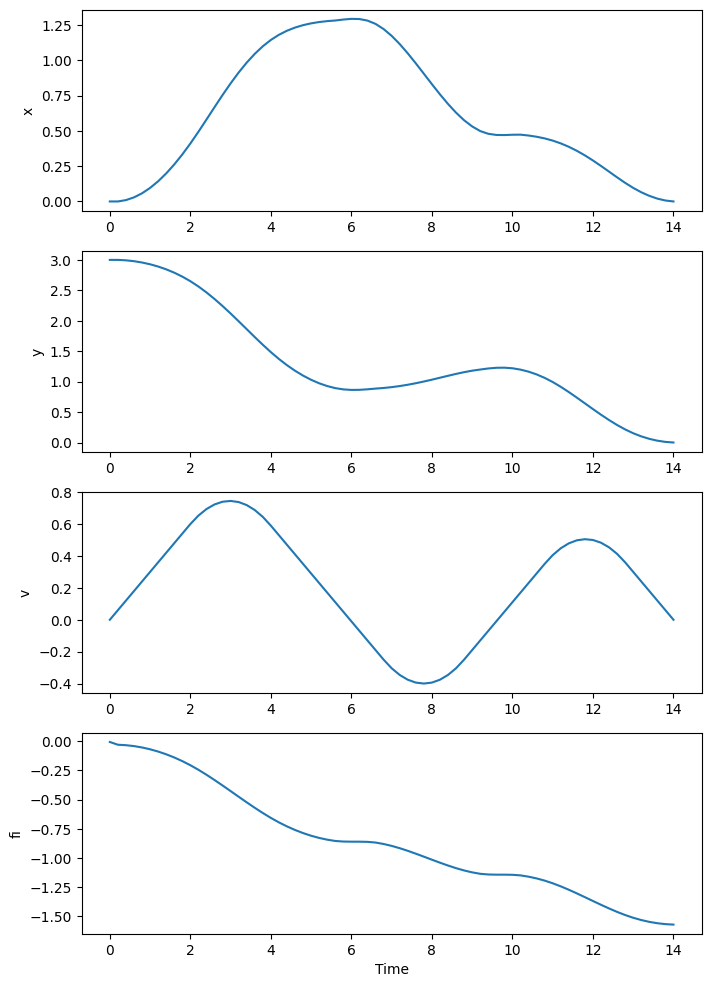

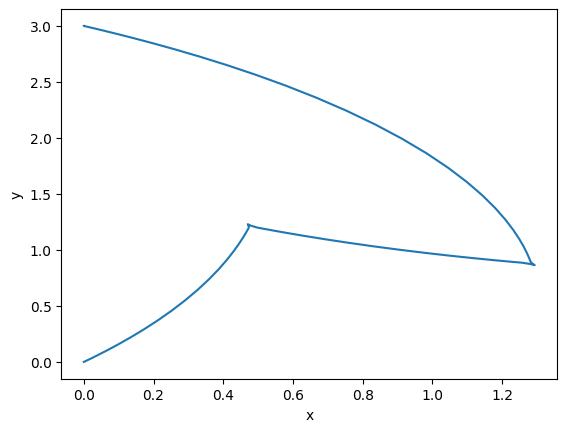

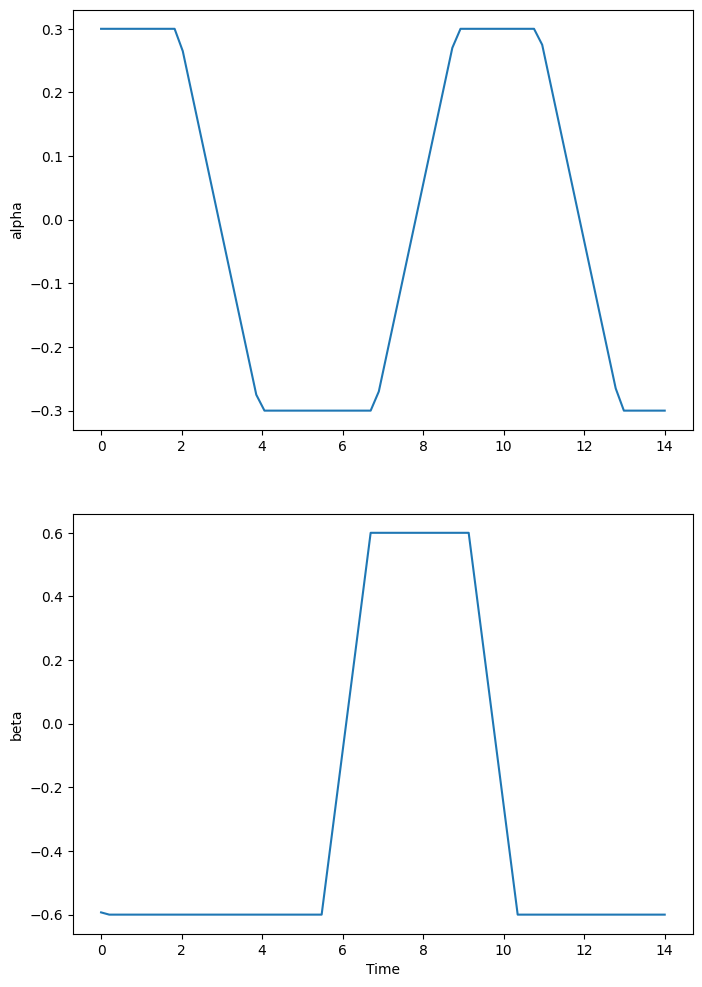

In [15]:
# Write your code here:
import pyomo.environ
import numpy as np

deltaT=0.2
N=70
lr=1.738
lf=1.738

model = pyo.ConcreteModel()

model.x = pyo.Var(pyo.RangeSet(0,N), bounds=[-20,20]) # This creates a decision variable vector z with index 0 and 1. You can call model.z[0] and model.z[1]
model.y = pyo.Var(pyo.RangeSet(0,N), bounds=[-5,10])
model.v = pyo.Var(pyo.RangeSet(0,N), bounds=[-10,10])
model.fi = pyo.Var(pyo.RangeSet(0,N), bounds=[-2*np.pi,2*np.pi])

model.alpha = pyo.Var(pyo.RangeSet(0,N-1),bounds=(-0.3,0.3))
model.beta = pyo.Var(pyo.RangeSet(0,N-1),bounds=(-0.6,0.6))

model.obj=pyo.Objective(expr=sum(model.x[i]**2+model.y[i]**2+model.v[i]**2+(model.fi[i]+np.pi/2)**2 for i in range(N-2,N+1)),sense=pyo.minimize)

model.Constraint=pyo.ConstraintList()

model.Constraint.add(expr=model.x[0]==0)
model.Constraint.add(expr=model.y[0]==3)
model.Constraint.add(expr=model.v[0]==0)
model.Constraint.add(expr=model.fi[0]==0)

model.Constraint.add(expr=model.x[N]==0)
model.Constraint.add(expr=model.y[N]==0)
model.Constraint.add(expr=model.v[N]==0)
model.Constraint.add(expr=model.fi[N]==-np.pi/2)

for i in range(1,N+1):
    model.Constraint.add(expr=model.x[i]==model.x[i-1]+model.v[i-1]*pyo.cos(model.fi[i-1]+model.beta[i-1])*deltaT)
    model.Constraint.add(expr=model.y[i]==model.y[i-1]+model.v[i-1]*pyo.sin(model.fi[i-1]+model.beta[i-1])*deltaT)
    model.Constraint.add(expr=model.v[i]==model.v[i-1]+model.alpha[i-1]*deltaT)
    model.Constraint.add(expr=model.fi[i]==model.fi[i-1]+model.v[i-1]*pyo.sin(model.beta[i-1])*deltaT/lr)

for i in range(N-1):
    model.Constraint.add(expr=model.beta[i+1]-model.beta[i]<=0.2)
    model.Constraint.add(expr=model.beta[i+1]-model.beta[i]>=-0.2)
    model.Constraint.add(expr=model.alpha[i+1]-model.alpha[i]<=0.06)
    model.Constraint.add(expr=model.alpha[i+1]-model.alpha[i]>=-0.06)

solution=pyo.SolverFactory('ipopt').solve(model)

x_values = np.zeros(N+1)
y_values = np.zeros(N+1)
v_values = np.zeros(N+1)
fi_values = np.zeros(N+1)
alpha_values = np.zeros(N)
beta_values = np.zeros(N)

for i in range(N+1):
    x_values[i] = pyo.value(model.x[i])
    y_values[i] = pyo.value(model.y[i])
    v_values[i] = pyo.value(model.v[i])
    fi_values[i] = pyo.value(model.fi[i])
for i in range(N):
    alpha_values[i] = pyo.value(model.alpha[i])
    beta_values[i] = pyo.value(model.beta[i])

time=np.linspace(0,N*deltaT,N+1)
time2=np.linspace(0,N*deltaT,N)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(8, 12))

axs[0].plot(time, x_values)
axs[0].set_ylabel('x')

axs[1].plot(time, y_values)
axs[1].set_ylabel('y')

axs[2].plot(time, v_values)
axs[2].set_ylabel('v')

axs[3].plot(time, fi_values)
axs[3].set_ylabel('fi')
plt.xlabel('Time')
plt.show()

plt.plot(x_values, y_values)


plt.xlabel('x')
plt.ylabel('y')

plt.show()


fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].plot(time2, alpha_values)
axs[0].set_ylabel('alpha')

axs[1].plot(time2, beta_values)
axs[1].set_ylabel('beta')
plt.xlabel('Time')
plt.show()

***

# <font color = blue> 2. Unconstrained Linear Finite Time Optimal Control - Batch </font>

Consider the discrete-time dynamic system with the following state space representation:

\begin{align}
 \label{eq:Dyn_Sys}
    \begin{bmatrix}
      x_1(k+1) \\
      x_2(k+1) \end{bmatrix} = \begin{bmatrix}
      0.77 & -0.35 \\
      0.49 & 0.91
    \end{bmatrix}
    \begin{bmatrix}
      x_1 (k) \\
      x_2 (k)
    \end{bmatrix} + \begin{bmatrix}
      0.04 \\
      0.15
    \end{bmatrix} u(k)
\end{align}

We want to design a linear quadratic optimal control for this system with a finite horizon $N = 50$. We set the following cost matrices:

\begin{align}
Q = \left[ \begin{matrix}
500 & 0 \\ 0 & 100  \end{matrix} \right],  \ \ R = 1, \ \
P = \left[ \begin{matrix}
1500 & 0 \\
0 & 100
\end{matrix} \right],
\end{align}
and assume that the initial state is $x(0) = [ 1, -1]^T$;

$\textbf{Part (a)}$

Determine the optimal  set of inputs
\begin{align}
U_0= \left[\begin{matrix}
u_0 \\ u_1 \\ \vdots \\ u_{N-1} \\
\end{matrix}\right]
\end{align}

through the Batch Approach, i.e. by writing the dynamic equations as follows:
\begin{align*}
\left[ \begin{array}{c} x_0 \\ x_1 \\ \vdots \\ \vdots \\ x_N \end{array} \right] & = \left[ \begin{array}{c} I \\ A \\ \vdots \\ \vdots \\ A^N \end{array} \right] x(0)+ \left[ \begin{array}{cccc} 0 & \cdots & \cdots & 0 \\ B & 0 & \cdots & 0 \\ AB & B & \cdots & 0 \\ \vdots & \ddots & \ddots & 0 \\ A^{N-1}B & \cdots & AB & B \end{array} \right] \left[ \begin{array}{c} u_0 \\ u_1 \\ \vdots \\ \vdots \\ u_{N-1} \end{array} \right] \\ & = \mathcal{S}^x x(0) + \mathcal{S}^u U_0,
\end{align*}
and using the formula:
\begin{align*}
U_0^*(x(0)) & = - (\mathcal{S}^{uT}\overline{Q}\mathcal{S}^u + \overline{R})^{-1}\mathcal{S}^{uT}\overline{Q}\mathcal{S}^x x(0)  \, ,
\end{align*}
and calculate the optimal cost $J_0^*(x(0))$:
\begin{align*}
J_0^*(x(0)) & = x(0)^T(\mathcal{S}^{xT}\overline{Q}\mathcal{S}^x - \mathcal{S}^{xT}\overline{Q}\mathcal{S}^u(\mathcal{S}^{uT}\overline{Q}\mathcal{S}^u + \overline{R})^{-1}\mathcal{S}^{uT}\overline{Q}\mathcal{S}^x)x(0)\, .
\end{align*}

Print out $U_0^*(x(0))^T$ and $J_0^*(x(0))$.
*Hint:* To efficiently concatenate the matrices use $\texttt{scipy.linalg.block_diag}$ and $\texttt{numpy.kron}$.

### <font color=red> Delivarable 2a (10 pts): write your answer in the code cell below.</font>

In [1]:
import numpy as np
import scipy as sp
from scipy.linalg import block_diag
from numpy.linalg import inv

# The function Sx_Su is given to you. Fill in the blanks to write lqrBatch function that calls Sx_Su function.
# Then call lqrBatch function for the given problem data to calculate U0_star and J0_star.

def Sx_Su(A, B, N):

    nX = np.size(A,0)
    nU = np.size(B,1)

    Sx = np.eye(nX)
    A_tmp = A
    for i in range(N):
        Sx = np.vstack((Sx, A_tmp))
        A_tmp = A_tmp @ A

    SxB = Sx @ B
    Su = np.zeros((nX*(N+1),nU*N))

    for j in range(N):
        Su_tmp = np.vstack((np.zeros((nX, nU)), SxB[:-nX,:]))
        Su[:, j] = Su_tmp.reshape(Su_tmp.shape[0], )
        SxB = Su_tmp

    return Sx, Su

# TODO: Fill in the blanks (...):

def lqrBatch(A,B,Q,R,PN,N):
    Sx, Su = Sx_Su(A, B, N)

    Qbar  = np.kron(np.eye(N), Q)
    Qbar=block_diag(Qbar,PN)
    Rbar = np.kron(np.eye(N), R)
    QSu = Qbar.dot(Su)

    H = Su.T.dot(QSu) + Rbar
    F = ((Sx.T).dot(QSu))

    K = -inv(H).dot(F.T)
    print("Sx",Sx.T.shape,"Su",Su.shape,"Qbar",Qbar.shape,"QSu",QSu.shape,"H",H.shape,"F",F.shape,"K",K.shape)
    P0 = sp.linalg.solve_discrete_are(A, B, Q, R)
    print("P0",P0.shape)
    return K,P0

# Solve the finite-horizon, LQR problem for a time-invariant discrete-time
# system.  A is nX-by-nX, B is nX-by-nU, (Q,R,PN) are symmetric and positive
# semidefinite (R positive-definite), and of dimension nX-by-nX, nU-by-nU,
# and nX-by-nX, respectively.   N denotes the number of time-steps.  The
# output argument K is N*nU-by-nX, so that K*x0 is the (vertically
# concatenated) sequence of optimal inputs, {u_0, u_1, ..., u_{N-1}}.  The
# optimal cost, from any initial condition x0, is x0'*P0*x0.

# Problem data
A = np.array([[0.77, -0.35],
              [0.49, 0.91]])
B = np.array([[0.04],
              [0.15]])
Q = np.diag((500,100))
R = 1
PN = np.diag((1500,100))
x0 = np.array([1,-1])
N = 50

# call lqrBatch function and calculate U0_star and J0_star
K,P0 = lqrBatch(A,B,Q,R,PN,N)
U0_star = K.dot(x0)     # sequence of optimal inputs
J0_star = x0.T.dot(P0).dot(x0)
    # the optimal cost

print('K= ', K)
print('P0= ',P0)
print('U0_star = ',U0_star)
print('J0_star = ',J0_star)



Sx (2, 102) Su (102, 50) Qbar (102, 102) QSu (102, 50) H (50, 50) F (2, 50) K (50, 2)
P0 (2, 2)
K=  [[-2.04606782e+00 -6.12786516e+00]
 [-2.52996625e+00  1.27389726e+00]
 [-1.50777708e+00  1.49392578e+00]
 [-7.64065175e-01  8.83586265e-01]
 [-3.64021361e-01  4.46595224e-01]
 [-1.68736910e-01  2.12534786e-01]
 [-7.72045769e-02  9.84667784e-02]
 [-3.51006267e-02  4.50416686e-02]
 [-1.59080807e-02  2.04754233e-02]
 [-7.19841996e-03  9.27917145e-03]
 [-3.25472325e-03  4.19870417e-03]
 [-1.47102150e-03  1.89839019e-03]
 [-6.64718235e-04  8.57999591e-04]
 [-3.00339700e-04  3.87707288e-04]
 [-1.35695693e-04  1.75177477e-04]
 [-6.13067658e-05  7.91463992e-05]
 [-2.76977971e-05  3.57580058e-05]
 [-1.25135138e-05  1.61551132e-05]
 [-5.65342883e-06  7.29867454e-06]
 [-2.55413517e-06  3.29743788e-06]
 [-1.15391941e-06  1.48973342e-06]
 [-5.21323015e-07  6.73038874e-07]
 [-2.35525649e-07  3.04068600e-07]
 [-1.06406829e-07  1.37373468e-07]
 [-4.80729556e-08  6.20632067e-08]
 [-2.17186115e-08  2.8039

$\textbf{Part (b)}$

Verify the results of the previous point by solving a numerical optimization problem.
In fact, the cost can be written as a function of  $U_0$  as follows:

\begin{align*}
J_0(x(0),U_0) & = (\mathcal{S}^x x(0) + \mathcal{S}^u U_0)^T\overline{Q}(\mathcal{S}^x x(0) + \mathcal{S}^u U_0) + U_0^T\overline{R}U_0 \\
    & = U_0^T H U_0 + 2 x(0)^TFU_0 + x(0)^T \mathcal{S}^{xT}\overline{Q}\mathcal{S}^x x(0),
\end{align*}

where $H := \mathcal{S}^{uT}\overline{Q}\mathcal{S}^u + \overline{R}$ and $F := \mathcal{S}^{xT}\overline{Q}\mathcal{S}^u$,
and then minimized by solving a quadratic minimization problem.
Check that the optimizer $U_0^*$ and the optimum $J_0(x(0),U_0^*)$ correspond to the ones determined analytically in the previous point.

*Note:* Make sure you compute the unconstrained solution here and do not have any linear constraints. Use $\texttt{cvxopt.solvers.qp}$ to solve the unconstrained quadratic program.

### <font color=red> Delivarable 2b (10 pts): write your answer in the code cell below.</font>

In [2]:
# use cvxopt to solve quadratic program
# H and F are given and no constraint is included
import cvxopt
from cvxopt import matrix, solvers

# Fill in the blanks (...):
Sx, Su = Sx_Su(A, B, N)
Qbar  = np.kron(np.eye(N), Q)
Qbar=block_diag(Qbar,PN)
Rbar = np.kron(np.eye(N), R)
QSu = Qbar.dot(Su)

H = Su.T.dot(QSu) + Rbar
F = ((Sx.T).dot(QSu))


P = H*2
     # write P and q to solve the quadratic program using cvxopt
q = (x0.T.dot(F))*2

P = cvxopt.matrix(P, tc='d')
q = cvxopt.matrix(q.T, tc='d')
sol = cvxopt.solvers.qp(P,q)

print('U0_star =', sol['x'])
print('J0_star =', sol['primal objective']+x0.T.dot(Sx.T).dot(Qbar).dot(Sx).dot(x0))

U0_star = [ 4.08e+00]
[-3.80e+00]
[-3.00e+00]
[-1.65e+00]
[-8.11e-01]
[-3.81e-01]
[-1.76e-01]
[-8.01e-02]
[-3.64e-02]
[-1.65e-02]
[-7.45e-03]
[-3.37e-03]
[-1.52e-03]
[-6.88e-04]
[-3.11e-04]
[-1.40e-04]
[-6.35e-05]
[-2.87e-05]
[-1.30e-05]
[-5.85e-06]
[-2.64e-06]
[-1.19e-06]
[-5.40e-07]
[-2.44e-07]
[-1.10e-07]
[-4.98e-08]
[-2.25e-08]
[-1.02e-08]
[-4.59e-09]
[-2.07e-09]
[-9.37e-10]
[-4.23e-10]
[-1.91e-10]
[-8.64e-11]
[-3.90e-11]
[-1.76e-11]
[-7.96e-12]
[-3.60e-12]
[-1.63e-12]
[-7.33e-13]
[-3.32e-13]
[-1.50e-13]
[-6.87e-14]
[-2.94e-14]
[-1.46e-14]
[-5.84e-15]
[-2.82e-15]
[-1.13e-15]
[-8.11e-16]
[-2.93e-16]

J0_star = 1872.3385566528873


***

# <font color=blue> 3. Constrained Finite Time Optimal Control - Sparse vs Dense QP Formulations </font>

Consider CFTOC of a discrete-time double-integrator system:
\begin{align}
\min_{\substack{ u_0,\dots,u_{N-1} \\ x_1,\dots,x_N }} ~&~ x_N^TPx_N + \displaystyle{\sum}_{k=0}^{N-1}  x_k^TQx_k + u_k^TRu_k \\
\text{subject to} ~&~ x_{k+1}=
\begin{bmatrix} 1 & 1 \\  0 & 1 \end{bmatrix}
x_k
+
\begin{bmatrix} 0 \\ 1 \end{bmatrix}
u_k \\
& -1 \leq u_k \leq 1, ~k \in \left\{ 0, \ldots, N-1 \right\} \\
& \begin{bmatrix} -15 \\ -15 \end{bmatrix} \leq x(k) \leq \begin{bmatrix} 15 \\ 15 \end{bmatrix}, ~k \in \left\{ 1, \ldots, N \right\}
\end{align}
where $N = 3$, $P = Q = \mathcal{I}_{2 \times 2}$, $R = 0.1$.

$\textbf{Part (a)}$

Let  $x_0 = [-1, -1]^T$.
Determine the QP $\textbf{dense}$ formulation when you substitute the dynamics in the CFTOC. That is, determine $H, f, c, A, b$ for the following problem:
\begin{align*}
\min_{U_0} ~&~ \frac{1}{2} U_0^T H U_0 + f^T U_0 + c\\
\text{subject to} ~&~ A U_0 \leq b.
\end{align*}

where $U_0 =\left[ u_0^T, u_1^T, \ldots, u_{N-1}^T \right]^T$. Write the code to synthesize these matrices and then compute the solution using $\texttt{cvxopt}$. Note that you can drop the $c$ term when using $\texttt{cvxopt}$. You should NOT have any $Aeq$ or $beq$. Make sure to turn in your code and outputs (synthesized matrices, solver solution and optimal value). How many $0$'s are in $A$? In $H$?

### <font color=red> Delivarable 3a (10 pts): write your answer in the code cell below.</font>

In [6]:
import numpy as np
import scipy as sp
from scipy.linalg import block_diag
from numpy.linalg import inv
import time
from ttictoc import tic,toc
import cvxopt

def Sx_Su(A, B, N):

    nX = np.size(A,0)
    nU = np.size(B,1)

    Sx = np.eye(nX)
    A_tmp = A
    for i in range(N):
        Sx = np.vstack((Sx, A_tmp))
        A_tmp = A_tmp @ A

    SxB = Sx @ B
    Su = np.zeros((nX*(N+1),nU*N))

    for j in range(N):
        Su_tmp = np.vstack((np.zeros((nX, nU)), SxB[:-nX,:]))
        Su[:, j] = Su_tmp.reshape(Su_tmp.shape[0], )
        SxB = Su_tmp

    return Sx, Su



# Define state and controller matricies
nX = 2
nU = 1
Ax = np.array([[1, 1],
               [0, 1]])
Bx = np.array([[0],
              [1]])
Q = np.eye(2)
P = np.eye(2)
R = 0.1
N = 3
x0 = np.array([[-1],[-1]])

# Define state and input constraints
ULlim = -1
UUlim = 1
xLlim = np.array([-15, -15])
xUlim = np.array([15, 15])

Sx, Su = Sx_Su(Ax, Bx, N)

# Fill in the blanks (...):
Qbar  = np.kron(np.eye(N), Q)
Qbar=block_diag(Qbar,P)
Rbar = np.kron(np.eye(N), R)
QSu = Qbar.dot(Su)

H = Su.T.dot(QSu) + Rbar
F = ((Sx.T).dot(QSu))

K = -inv(H).dot(F.T)
#print("Sx",Sx.T.shape,"Su",Su.shape,"Qbar",Qbar.shape,"QSu",QSu.shape,"H",H.shape,"F",F.shape,"K",K.shape)
P0 = sp.linalg.solve_discrete_are(Ax, Bx, Q, R)

c = x0.T@Sx.T@Qbar@Sx@x0

A = np.concatenate([np.kron(np.array([[1],[-1]]),np.eye(3)), Su, -Su], axis = 0)
b = np.concatenate([np.ones((nX*N,1)), 15*np.ones((2*nX*(N+1),1))-np.concatenate([Sx,-Sx], axis = 0)@x0], axis = 0)

#print("A",A.shape,"b",b.shape,"c",c.shape)
P =  2 * H
#print("P",P)
#print("(Sx.T).dot(Qbar).dot(Sx)",(Sx.T).dot(Qbar).dot(Sx))
#print("H",H)
q = 2 * x0.T @ F
##print("q",q)
P = cvxopt.matrix(P, tc='d')
q = cvxopt.matrix(q.T, tc='d')
G = cvxopt.matrix(A, tc='d')
h = cvxopt.matrix(b, tc='d')

tic()
sol = cvxopt.solvers.qp(P,q,G,h)
t_dense = toc()
print('Elapsed time:',t_dense)

Uopt_dense = sol['x']
Jopt_dense = sol['primal objective']+c

print('The optimal control sequence=', Uopt_dense)
print('The optimal cost=', Jopt_dense)
print('The H matrix=', H)
print('The F matrix=', F)
print('The c matrix=', c)
print('The A matrix=', A)
print('The b matrix:', b)
print('Number of zeros in A matrix=', np.size(A,0)*np.size(A,1) - np.count_nonzero(A))
print('Number of zeros in H matrix=', np.size(H,0)*np.size(H,1) - np.count_nonzero(H))

     pcost       dcost       gap    pres   dres
 0: -2.4779e+01 -8.2232e+02  1e+03  1e-01  6e-16
 1: -1.9633e+01 -8.5580e+01  7e+01  3e-03  2e-16
 2: -2.0823e+01 -2.6044e+01  5e+00  2e-04  8e-17
 3: -2.1589e+01 -2.2124e+01  5e-01  1e-05  4e-17
 4: -2.1717e+01 -2.1764e+01  5e-02  4e-08  9e-17
 5: -2.1726e+01 -2.1729e+01  4e-03  2e-16  6e-17
 6: -2.1726e+01 -2.1726e+01  5e-05  2e-16  1e-16
 7: -2.1726e+01 -2.1726e+01  5e-07  1e-16  3e-17
Optimal solution found.
Elapsed time: 0.014313763000245672
The optimal control sequence= [ 1.00e+00]
[ 9.13e-01]
[-8.30e-01]

The optimal cost= [[12.27427386]]
The H matrix= [[8.1 4.  1. ]
 [4.  3.1 1. ]
 [1.  1.  1.1]]
The F matrix= [[ 3.  1.  0.]
 [11.  5.  1.]]
The c matrix= [[34.]]
The A matrix= [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]
 [-1. -0. -0.]
 [-0. -1. -0.]
 [-0. -0. -1.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  1.  0.]
 [ 2.  1.  0.]
 [ 1.  1.  1.]
 [-0. -0. -0.]
 [-0. -0. -0.]
 [-0. -0. -0.]
 [-1

$\textbf{Part (b)}$

Let  $x_0 = [-1, -1]^T$.
Determine the QP $\textbf{sparse}$ formulation when you do NOT substitute the dynamics in the CFTOC. That is, what are $H, f, A, b, Aeq, beq$ for the following problem:
\begin{align*}
\min_{z} ~&~ \frac{1}{2} z^T H z + f^T z \\
\text{subject to} ~&~ Az \leq b \\
&~ A_{eq}z = b_{eq}.
\end{align*}

where $z = [x_1^T, \ldots, x_N^T, u_0^T, \ldots, u_{N-1}^T]^T$. This requires using $Aeq$ and $beq$. Again, write a script to synthesize these matrices and compute the solution using $\texttt{cvxopt}$. Make sure to turn in the outputs (synthesized matrices, $\texttt{cvxopt.solvers.qp}$ solution and optimal value).  How many $0$'s are in $A$? In $H$? In $Aeq$?

### <font color=red> Delivarable 3b (10 pts): write your answer in the code cell below.</font>

In [7]:
Q = np.eye(2)
P = np.eye(2)
R = 0.1
N = 3
x0 = np.array([[-1],[-1]])

H = sp.linalg.block_diag(np.kron(np.eye(N-1),Q),P,np.kron(np.eye(N),R))

Aeq = np.concatenate([np.concatenate([np.eye(2), np.zeros((2,2)), np.zeros((2,2)), -Bx, np.zeros((2,1)), np.zeros((2,1))], axis = 1),
       np.concatenate([-Ax, np.eye(2), np.zeros((2,2)), np.zeros((2,1)), -Bx, np.zeros((2,1))], axis = 1),
       np.concatenate([np.zeros((2,2)), -Ax, np.eye(2), np.zeros((2,1)), np.zeros((2,1)), -Bx], axis = 1)], axis = 0)

beq = np.concatenate([Ax, np.zeros((2,2)), np.zeros((2,2))], axis = 0)@x0

# Fill in the blanks (...):


A_x = np.array([[1,0],[0,1],[-1,0],[0,-1]])

E = np.concatenate([-A_x, np.zeros((18,2))], axis = 0)

A_u = np.array([[1],[-1]])
Bu = np.array([[1],[1]])

A = np.concatenate([np.concatenate([np.zeros((4,6)), np.zeros((4,3))], axis = 1),
                    np.concatenate([A_x, np.zeros((4,4)), np.zeros((4,3))], axis = 1),
                    np.concatenate([np.zeros((4,2)), A_x, np.zeros((4,2)), np.zeros((4,3))], axis = 1),
                    np.concatenate([np.zeros((4,4)), A_x, np.zeros((4,3))], axis = 1),
                    np.concatenate([np.zeros((2,6)), A_u, np.zeros((2,2))], axis = 1),
                    np.concatenate([np.zeros((2,6)), np.zeros((2,1)), A_u, np.zeros((2,1))], axis = 1),
                    np.concatenate([np.zeros((2,6)), np.zeros((2,2)), A_u], axis = 1) ], axis = 0)
P = 2 * H
q = np.zeros((P.shape[0],1))
c = x0.T @ Q @ x0

P = cvxopt.matrix(P, tc='d')
q = cvxopt.matrix(q, tc='d')
G = cvxopt.matrix(A, tc='d')
h = cvxopt.matrix(b, tc='d')
Aeq = cvxopt.matrix(Aeq, tc='d')
beq = cvxopt.matrix(beq, tc='d')

tic()
sol = cvxopt.solvers.qp(P,q,G,h,Aeq,beq)
t_sparse = toc()
print('Elapsed time:',t_sparse)

Uopt_sparse = sol['x']
Jopt_sparse = sol['primal objective']+c
Uopt_sparse_array = np.asarray(Uopt_sparse)

print('Uopt_sparse=', sol['x'])
print('Jopt_sparse=', Jopt_sparse)


print('The optimal control sequence=', np.asarray(Uopt_sparse_array[6:]))
print('The optimal cost=', Jopt_sparse)
print('The H matrix=', H)
print('The F matrix=', q)
print('The A matrix=', A)
print('The b matrix=', b)
print('Number of zeros in A matrix=', np.size(A,0)*np.size(A,1) - np.count_nonzero(A))
print('Number of zeros in H matrix=', np.size(H,0)*np.size(H,1) - np.count_nonzero(H))


print('time to solve the dense formulation=', t_dense)
print('time to solve the sparse formulation=', t_sparse)

     pcost       dcost       gap    pres   dres
 0:  9.8662e+00 -1.4454e+03  1e+03  3e-16  4e-15
 1:  8.3714e+00 -3.4391e+01  4e+01  6e-16  5e-15
 2:  7.1733e+00  6.0794e+00  1e+00  1e-16  5e-16
 3:  6.9855e+00  6.9294e+00  6e-02  2e-16  7e-16
 4:  6.9518e+00  6.9473e+00  5e-03  1e-16  4e-16
 5:  6.9478e+00  6.9477e+00  7e-05  2e-16  7e-16
 6:  6.9477e+00  6.9477e+00  7e-07  2e-16  4e-16
Optimal solution found.
Elapsed time: 0.020789187001355458
Uopt_sparse= [-2.00e+00]
[ 1.00e+00]
[-1.00e+00]
[ 5.02e-01]
[-4.98e-01]
[ 4.56e-02]
[ 2.00e+00]
[-4.98e-01]
[-4.56e-01]

Jopt_sparse= [[8.94771851]]
The optimal control sequence= [[ 1.99999866]
 [-0.49792342]
 [-0.45643204]]
The optimal cost= [[8.94771851]]
The H matrix= [[1.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.1 0.  0. ]
 [0.

$\textbf{Part (c)}$

Compare the $\texttt{cvxopt.solvers.qp}$ solver times compare using $\texttt{tic toc}$ commands. Check your solutions to make sure the two methods get the same answer.

### <font color=red> Delivarable 3c (3 pts): write your responses in your PDF submission or in a text cell here

#Ans:
In this problem, time to solve the dense formulation is shorter than time to slove the sparse formulation.

That is because dense formulation involves constructing a large block diagonal matrix. The dense formulation is generally faster for small to medium-sized problems, but it can become computationally expensive for large problems due to the large number of non-zero elements in the matrices.

On the other hand, the sparse formulation involves constructing a sparse matrix that has a large number of zero elements.I think The sparse formulation is generally faster for large problems with a large number of zero elements in the matrices.

In this problem I think, because there is a relative small problem, so use dense formulation would be faster

# <font color=blue> Question 4. HW4 Summary/Wrapper </font>

Rate your confidence in your homework solutions and understanding of material.

A) I am very confident and feel great about this content.

B) I am somewhat confident.

C) I am not feeling confident.

Any additional comments? (Comments are optional, but please rate either A/B/C. All choices will receive the full 5 points.)

### <font color=red> Deliverable 4 (5 pts): Write your answer in your PDF submission or in a text cell here </font>

#Ans

I choose B)
After I reviewing the powerpoint, I found some formula in it are still hard to understand and put it into my homework